## Import library

In [1]:
import cv2, os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from sklearn.utils import shuffle
from tqdm import tqdm
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from contextlib import redirect_stdout

%matplotlib inline

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Konstanta 

In [2]:
data_path = 'ulos/dataset/'

IMG_SIZE = 64
NUM_CLASS = 6
NUM_KFOLD = 5

## Data preprocessing
### Memuat dataset dan memilih data training dan testing

In [3]:
img_data_list = []
for dataset in tqdm(os.listdir(data_path)):
    path = os.path.join(data_path, dataset)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_data_list.append(img)

img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,), dtype='int64')
names = ['Bintang Maratur', 'Mangiring', 'Ragi Hotang', 'Ragi Idup', 'Sadum', 'Sibolang']
labels[0:17]=0
labels[17:73]=2
labels[73:79]=3
labels[79:124]=1
labels[124:214]=4
labels[214:225]=5

#one hot encoding
Y = np_utils.to_categorical(labels,NUM_CLASS)

#shuffle dataset
x,y = shuffle(img_data, Y, random_state=2)

#Take the shape of the image
input_shape=img_data[0].shape

100%|██████████| 225/225 [01:28<00:00,  3.45it/s]


## Membuat model CNN 

In [10]:
def createModel():
    model = Sequential()

    #model.add(InputLayer(input_shape=input_shape))
    #1
    model.add(Conv2D(filters=64, kernel_size=5, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=2, padding='same'))

    #2
    model.add(Conv2D(filters=64, kernel_size=(5,5), strides=2, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), padding='same'))

    #3
    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=2, padding='same'))
    
    #4
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=2, padding='same'))

    model.add(Dropout(0.25))
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(NUM_CLASS, activation='softmax'))
    
    return model

## Melakukan training data dengan menerapkan cross validation K-Fold 

In [12]:
counter=1
max_acc = 0
highest_model = 0
seed = 6
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=NUM_KFOLD, shuffle=True, random_state=seed)

adam = Adam(lr=1e-3)
epoch=50
batchsize = 25

for train_index, test_index in kfold.split(x, y[:,0]):
    print("Iterasi ke-{}".format(counter))
    print("Train : {}\nTest : {}".format(train_index, test_index))
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Menyimpan index training masing-masing fold
    np.savetxt('out_ulos/cv_train_ulos-'+str(counter)+'.csv', train_index, fmt='%d', delimiter=',')
    np.savetxt('out_ulos/cv_test_ulos-'+str(counter)+'.csv', test_index, fmt='%d', delimiter=',')
    
    model = createModel()
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    hist = model.fit(X_train, y_train, epochs=epoch, batch_size=batchsize, validation_data=(X_test, y_test), verbose=1)
    score = model.evaluate(X_test, y_test, batch_size=batchsize, verbose=0)
    
    #Menyimpan model masing-masing fold
    model.save('out_ulos/K-Fold-model-'+str(counter)+'.h5')
    
    #Menyimpan history model masing-masing fold
    with open('out_ulos/hist-model-'+str(counter), 'wb') as f:
        pickle.dump(hist.history, f)
        
    print('K-Fold-{}'.format(counter))
    print('=========================================')
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('=========================================\n')
    
    if score[1] > max_acc:
        max_acc = score[1]
        highest_model = counter
    
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    counter+=1

#Menampilkan k-fold ke berapa yang menghasilkan accuracy paling tinggi
print("Weight dengan akurasi tertinggi = KFold {}".format(highest_model))

Iterasi ke-1
Train : [  1   2   3   5   7   8   9  10  13  15  16  17  18  19  22  23  24  25
  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41  43  44  45
  46  47  48  50  51  53  54  55  56  57  58  59  60  62  63  64  65  66
  67  68  69  71  72  73  75  76  77  78  79  80  82  83  84  85  86  87
  88  89  90  91  92  93  94  96  97 101 102 103 104 105 106 108 112 113
 114 116 117 121 122 125 126 127 128 129 130 131 132 135 136 137 138 140
 141 143 144 145 146 147 149 150 151 152 153 154 155 157 159 161 162 163
 164 165 166 167 168 169 170 173 174 175 176 177 179 181 183 184 185 186
 187 188 189 190 191 192 194 195 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223]
Test : [  0   4   6  11  12  14  20  21  32  42  49  52  61  70  74  81  95  98
  99 100 107 109 110 111 115 118 119 120 123 124 133 134 139 142 148 156
 158 160 171 172 178 180 182 193 196 224]
Train on 179 samples, validate on 46 samples
Epoch 1/50
1

179/179 [==============================] - ETA: 1s - loss: 0.1671 - acc: 0.960 - ETA: 1s - loss: 0.1503 - acc: 0.940 - ETA: 1s - loss: 0.1911 - acc: 0.933 - ETA: 0s - loss: 0.1972 - acc: 0.930 - ETA: 0s - loss: 0.2055 - acc: 0.920 - ETA: 0s - loss: 0.2011 - acc: 0.920 - ETA: 0s - loss: 0.2038 - acc: 0.920 - 2s 11ms/step - loss: 0.2175 - acc: 0.9050 - val_loss: 0.9223 - val_acc: 0.6304
Epoch 40/50
179/179 [==============================] - ETA: 1s - loss: 0.0861 - acc: 0.960 - ETA: 1s - loss: 0.1631 - acc: 0.940 - ETA: 1s - loss: 0.3155 - acc: 0.893 - ETA: 0s - loss: 0.4338 - acc: 0.860 - ETA: 0s - loss: 0.4033 - acc: 0.872 - ETA: 0s - loss: 0.3857 - acc: 0.873 - ETA: 0s - loss: 0.3762 - acc: 0.868 - 2s 10ms/step - loss: 0.4056 - acc: 0.8603 - val_loss: 1.0026 - val_acc: 0.7174
Epoch 41/50
179/179 [==============================] - ETA: 1s - loss: 0.2297 - acc: 0.960 - ETA: 1s - loss: 0.3280 - acc: 0.880 - ETA: 0s - loss: 0.4492 - acc: 0.840 - ETA: 0s - loss: 0.5162 - acc: 0.810 - ETA: 

179/179 [==============================] - ETA: 1s - loss: 0.7880 - acc: 0.680 - ETA: 1s - loss: 0.8151 - acc: 0.700 - ETA: 1s - loss: 0.7884 - acc: 0.680 - ETA: 0s - loss: 0.7121 - acc: 0.720 - ETA: 0s - loss: 0.8289 - acc: 0.704 - ETA: 0s - loss: 0.9195 - acc: 0.660 - ETA: 0s - loss: 0.8579 - acc: 0.680 - 2s 11ms/step - loss: 0.8540 - acc: 0.6816 - val_loss: 1.2025 - val_acc: 0.4565
Epoch 27/50
179/179 [==============================] - ETA: 1s - loss: 1.2128 - acc: 0.520 - ETA: 1s - loss: 1.1016 - acc: 0.600 - ETA: 1s - loss: 1.0556 - acc: 0.600 - ETA: 0s - loss: 0.9967 - acc: 0.610 - ETA: 0s - loss: 0.9958 - acc: 0.608 - ETA: 0s - loss: 0.9375 - acc: 0.626 - ETA: 0s - loss: 0.9262 - acc: 0.634 - 2s 11ms/step - loss: 0.9259 - acc: 0.6313 - val_loss: 1.6039 - val_acc: 0.4348
Epoch 28/50
179/179 [==============================] - ETA: 1s - loss: 0.8498 - acc: 0.680 - ETA: 1s - loss: 0.7634 - acc: 0.700 - ETA: 1s - loss: 0.7722 - acc: 0.693 - ETA: 0s - loss: 0.7744 - acc: 0.710 - ETA: 

180/180 [==============================] - ETA: 1s - loss: 1.3718 - acc: 0.400 - ETA: 1s - loss: 1.4242 - acc: 0.320 - ETA: 0s - loss: 1.4452 - acc: 0.346 - ETA: 0s - loss: 1.4762 - acc: 0.380 - ETA: 0s - loss: 1.4808 - acc: 0.368 - ETA: 0s - loss: 1.4569 - acc: 0.380 - ETA: 0s - loss: 1.4384 - acc: 0.388 - 2s 10ms/step - loss: 1.4392 - acc: 0.3889 - val_loss: 1.4188 - val_acc: 0.4222
Epoch 14/50
180/180 [==============================] - ETA: 1s - loss: 1.4406 - acc: 0.280 - ETA: 1s - loss: 1.4410 - acc: 0.260 - ETA: 0s - loss: 1.4274 - acc: 0.320 - ETA: 0s - loss: 1.3870 - acc: 0.350 - ETA: 0s - loss: 1.3768 - acc: 0.344 - ETA: 0s - loss: 1.3584 - acc: 0.366 - ETA: 0s - loss: 1.3766 - acc: 0.394 - 2s 11ms/step - loss: 1.3748 - acc: 0.3944 - val_loss: 1.4129 - val_acc: 0.4222
Epoch 15/50
180/180 [==============================] - ETA: 1s - loss: 1.1944 - acc: 0.600 - ETA: 1s - loss: 1.3215 - acc: 0.460 - ETA: 1s - loss: 1.3487 - acc: 0.453 - ETA: 0s - loss: 1.4109 - acc: 0.390 - ETA: 

 200 205 206 209 210 211 212 223]
Train on 181 samples, validate on 44 samples
Epoch 1/50
181/181 [==============================] - ETA: 11s - loss: 1.8073 - acc: 0.04 - ETA: 5s - loss: 1.7478 - acc: 0.1800 - ETA: 3s - loss: 3.4405 - acc: 0.213 - ETA: 2s - loss: 4.4918 - acc: 0.270 - ETA: 1s - loss: 5.5360 - acc: 0.288 - ETA: 0s - loss: 6.6550 - acc: 0.280 - ETA: 0s - loss: 7.2700 - acc: 0.285 - 4s 20ms/step - loss: 7.5633 - acc: 0.2762 - val_loss: 12.4549 - val_acc: 0.2273
Epoch 2/50
181/181 [==============================] - ETA: 1s - loss: 13.5392 - acc: 0.16 - ETA: 1s - loss: 13.5392 - acc: 0.16 - ETA: 0s - loss: 13.3243 - acc: 0.17 - ETA: 0s - loss: 13.0557 - acc: 0.19 - ETA: 0s - loss: 13.1524 - acc: 0.18 - ETA: 0s - loss: 13.1094 - acc: 0.18 - ETA: 0s - loss: 13.0787 - acc: 0.18 - 2s 10ms/step - loss: 13.0013 - acc: 0.1934 - val_loss: 12.4549 - val_acc: 0.2273
Epoch 3/50
181/181 [==============================] - ETA: 1s - loss: 12.8945 - acc: 0.20 - ETA: 1s - loss: 11.9274 - a

181/181 [==============================] - ETA: 1s - loss: 10.9603 - acc: 0.32 - ETA: 1s - loss: 12.8945 - acc: 0.20 - ETA: 1s - loss: 12.6796 - acc: 0.21 - ETA: 0s - loss: 12.5721 - acc: 0.22 - ETA: 0s - loss: 12.8945 - acc: 0.20 - ETA: 0s - loss: 12.6796 - acc: 0.21 - ETA: 0s - loss: 12.8945 - acc: 0.20 - 2s 12ms/step - loss: 13.0013 - acc: 0.1934 - val_loss: 12.4549 - val_acc: 0.2273
Epoch 42/50
181/181 [==============================] - ETA: 1s - loss: 13.5392 - acc: 0.16 - ETA: 1s - loss: 14.1839 - acc: 0.12 - ETA: 1s - loss: 13.7541 - acc: 0.14 - ETA: 0s - loss: 13.5392 - acc: 0.16 - ETA: 0s - loss: 13.2813 - acc: 0.17 - ETA: 0s - loss: 12.8945 - acc: 0.20 - ETA: 0s - loss: 12.9866 - acc: 0.19 - 2s 10ms/step - loss: 13.0013 - acc: 0.1934 - val_loss: 12.4549 - val_acc: 0.2273
Epoch 43/50
181/181 [==============================] - ETA: 1s - loss: 12.8945 - acc: 0.20 - ETA: 1s - loss: 13.8616 - acc: 0.14 - ETA: 1s - loss: 13.1094 - acc: 0.18 - ETA: 0s - loss: 12.5721 - acc: 0.22 - E

181/181 [==============================] - ETA: 1s - loss: 9.6709 - acc: 0.400 - ETA: 1s - loss: 9.0261 - acc: 0.440 - ETA: 1s - loss: 9.8858 - acc: 0.386 - ETA: 0s - loss: 10.4768 - acc: 0.35 - ETA: 0s - loss: 10.1866 - acc: 0.36 - ETA: 0s - loss: 10.1007 - acc: 0.37 - ETA: 0s - loss: 9.5788 - acc: 0.4057 - 2s 11ms/step - loss: 9.7065 - acc: 0.3978 - val_loss: 9.5243 - val_acc: 0.4091
Epoch 29/50
181/181 [==============================] - ETA: 1s - loss: 9.0261 - acc: 0.440 - ETA: 1s - loss: 8.7038 - acc: 0.460 - ETA: 1s - loss: 9.0261 - acc: 0.440 - ETA: 0s - loss: 8.8650 - acc: 0.450 - ETA: 0s - loss: 9.1551 - acc: 0.432 - ETA: 0s - loss: 9.3485 - acc: 0.420 - ETA: 0s - loss: 9.5788 - acc: 0.405 - 2s 11ms/step - loss: 9.7065 - acc: 0.3978 - val_loss: 9.5243 - val_acc: 0.4091
Epoch 30/50
181/181 [==============================] - ETA: 1s - loss: 10.3156 - acc: 0.36 - ETA: 1s - loss: 10.9603 - acc: 0.32 - ETA: 1s - loss: 9.8858 - acc: 0.3867 - ETA: 0s - loss: 9.8320 - acc: 0.390 - ETA

## Load model yang memiliki accuracy tertinggi 

In [13]:
loaded_model = load_model('out_ulos/K-Fold-model-'+str(highest_model)+'.h5')

#Memuat index data training dan testing dari fold yang memiliki akurasi tertinggi 
i_train = pd.read_csv("out_ulos/cv_train_ulos-"+str(highest_model)+".csv", names=['index_train'], header=None)
i_test = pd.read_csv("out_ulos/cv_test_ulos-"+str(highest_model)+".csv", names=['index_test'], header=None)
X_train, X_test = x[i_train.values.flatten()], x[i_test.values.flatten()]
y_train, y_test = y[i_train.values.flatten()], y[i_test.values.flatten()]

#Membuka history model
with open('out_ulos/hist-model-'+str(highest_model), 'rb') as f:
    hist = pickle.load(f)

### Menampilkan kembali accuracy dan loss pada model 

In [14]:
score = loaded_model.evaluate(X_test, y_test, batch_size=batchsize, verbose=0)
print('=========================================')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('=========================================\n')

Test loss: 1.501426849676215
Test accuracy: 0.739130437374115



### Menampilkan plot history accuracy dan loss 

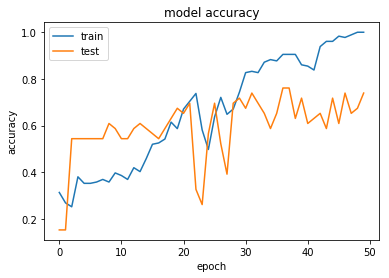

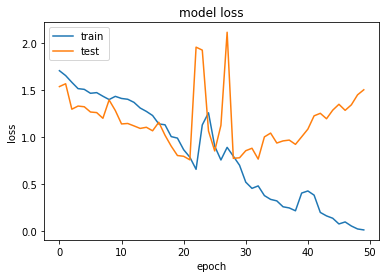

In [15]:
# summarize history for accuracy
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Melakukan validasi model dengan gambar dari masing-masing kelas 

In [16]:
#names = ['Bintang Maratur', 'Mangiring', 'Ragi Hotang', 'Ragi Idup', 'Sadum', 'Sibolang']
bm = 'ulos/validasi/bm.11.png'
hotang = 'ulos/validasi/hotang.49.png'
idup = 'ulos/validasi/idup.2.jpg'
mangiring = 'ulos/validasi/mangiring.1.png'
sadum = 'ulos/validasi/sadum.13.jpg'
sibolang = 'ulos/validasi/sibolang.2.jpg'

In [17]:
#Validasi gambar (kelas Bintang Maratur [0])
img_test = cv2.imread(bm, cv2.IMREAD_COLOR)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (IMG_SIZE, IMG_SIZE))
img_test = img_test.reshape(1, IMG_SIZE, IMG_SIZE, 3)
class_pred = loaded_model.predict_classes(img_test)
print(class_pred)

[0]


In [18]:
#Validasi gambar (kelas Mangiring [1])
img_test = cv2.imread(mangiring, cv2.IMREAD_COLOR)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (IMG_SIZE, IMG_SIZE))
img_test = img_test.reshape(1, IMG_SIZE, IMG_SIZE, 3)
class_pred = loaded_model.predict_classes(img_test)
print(class_pred)

[1]


In [19]:
#Validasi gambar (kelas Ragi Hotang [2])
img_test = cv2.imread(hotang, cv2.IMREAD_COLOR)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (IMG_SIZE, IMG_SIZE))
img_test = img_test.reshape(1, IMG_SIZE, IMG_SIZE, 3)
class_pred = loaded_model.predict_classes(img_test)
print(class_pred)

[4]


In [20]:
#Validasi gambar (kelas Ragi Idup [3])
img_test = cv2.imread(idup, cv2.IMREAD_COLOR)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (IMG_SIZE, IMG_SIZE))
img_test = img_test.reshape(1, IMG_SIZE, IMG_SIZE, 3)
class_pred = loaded_model.predict_classes(img_test)
print(class_pred)

[3]


In [21]:
#Validasi gambar (kelas Sadum [4])
img_test = cv2.imread(sadum, cv2.IMREAD_COLOR)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (IMG_SIZE, IMG_SIZE))
img_test = img_test.reshape(1, IMG_SIZE, IMG_SIZE, 3)
class_pred = loaded_model.predict_classes(img_test)
print(class_pred)

[4]


In [22]:
#Validasi gambar (kelas Sibolang [5])
img_test = cv2.imread(sibolang, cv2.IMREAD_COLOR)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = cv2.resize(img_test, (IMG_SIZE, IMG_SIZE))
img_test = img_test.reshape(1, IMG_SIZE, IMG_SIZE, 3)
class_pred = loaded_model.predict_classes(img_test)
print(class_pred)

[5]


### Menampilkan summary model dan menyimpan ke dalam file 

In [23]:
loaded_model.summary()
with open('out_ulos/modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 64)          102464    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 2, 2, 256)         295168    
__________